In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os 

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

from src.utils.time_series_procs import split_sequences

In [2]:
def plot_time_series_train_and_prediction_windows(df, model, cut_date):
    index = df['Data/Hora'].shape[0] - df[df['Data/Hora'] == cut_date].index[0] 
    index = -index
    y = df['R28D'].values
    d = df['Data/Hora'].values
    test_series = pd.DataFrame({'ccs28':y}, index=pd.to_datetime(d))
    pred_series = model.predict(x_test)
    diff = pred_series.shape[0] + index
    pred_series = pd.DataFrame({'ccs28-pred' : pred_series.squeeze()}, index=pd.to_datetime(d[index-diff:]))

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

    test_series.plot(ax=ax)
    ax.axvline(test_series.index[index], color='r') # end of train dataset
    pred_series[index:].plot(ax=ax)
    ax.grid(which="both")
    ax.legend(["train and test series", "end of train series", 'predicted'], loc="upper left")
    # ax.set_xlabel('Period', labelpad=20, fontsize=15)
    ax.set_ylabel('Compressive Strength - MPa', labelpad=20, fontsize=15)
    plt.show()

In [3]:
def get_times_series_data(df, cut_date, time_steps=3):
    columns = list(df.columns.drop(['R28D']))
    columns.append('R28D')
    df = df.reindex(columns=columns)
    df['Data/Hora'] = pd.to_datetime(df['Data/Hora'])
    df_train = df[df['Data/Hora'] < cut_date]
    df_test = df[df['Data/Hora'] >= cut_date]
    df_train = df_train.drop(['Data/Hora'], axis=1)
    df_test = df_test.drop(['Data/Hora'], axis=1)
    x_train, y_train = split_sequences(df_train.values, time_steps)
    x_test, y_test = split_sequences(df_test.values, time_steps)
    return x_train, y_train, x_test, y_test

In [4]:
# https://stackoverflow.com/questions/53938687/make-pipeline-with-standardscalar-and-kerasregressors

class StandardScaler3DShape():
    def __init__(self):
        self.scaler = StandardScaler()
    def fit_transform(self,X, y=None):
        X_new = self.scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new
        
    def fit(self,X, y=None):
        X_new = X.reshape(-1, X.shape[-1])
        self.scaler.fit(X_new)
        return self
    
    def transform(self,X,y=None):
        X_new = self.scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new

<h3>Force tensorflow use CPU only</h3>

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

<h3>Disable Tensorflow Warnings</h3>

In [6]:
# Disable warnings
# https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [7]:
name = "dados-historicos-partner_i-cement-CPIIE40.csv"
df_r3d_and_r7d = pd.read_csv("../../data/interim/" + "r3d-and-r7d-" + name)
df_r3d_only = pd.read_csv("../../data/interim/" + "r3d-only-" + name)
df_no_r3d_r7d = pd.read_csv("../../data/interim/" + "no-r3d-r7d-" + name)

In [8]:
seed = 47
scaler = StandardScaler()

In [9]:
cut_date = '2021-05-02'
TIME_STEPS = 3
time_steps_list = [1, 3, 5, 7, 10, 15, 20]

# Neural Network Long Short Term Memory - LSTM

# Baseline models

First we will train a baseline model and verify its overall performance on each of the three datasets.

# Configs:

1. Train Period: [01-01-2019, 2021-05-02)

2. Test Period:  (2021-05-02, 2021-11-31]

3. TIMESTEPS: [1, 3, 5, 7, 10, 15, 20]

4. Epochs: 100

5. Batch size: 32

6. LSTM Cells: 64

7. LSTM Layers: 1

8. Optimization Algorithm: Adam
    
    8.1. Learning Rate: 1e-2

In [10]:
def get_baseline_model(n_units=64, learning_rate=0.01):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.LSTM(units=n_units))
    model.add(tf.keras.layers.Dense(1))

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")])
    return model

<h3> Baseline model - Dataset: df_no_r3d_r7d</h3>

<h4>TIMESTEPS=3</h4>

In [11]:
df = df_no_r3d_r7d.copy()
x_train, y_train, x_test, y_test = get_times_series_data(df, cut_date, time_steps=3)
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

In [12]:
model = get_baseline_model()
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
rmse = model.evaluate(x_test, y_test, verbose=0)
print('RMSE: %.3f' % rmse[1])

RMSE: 3.871


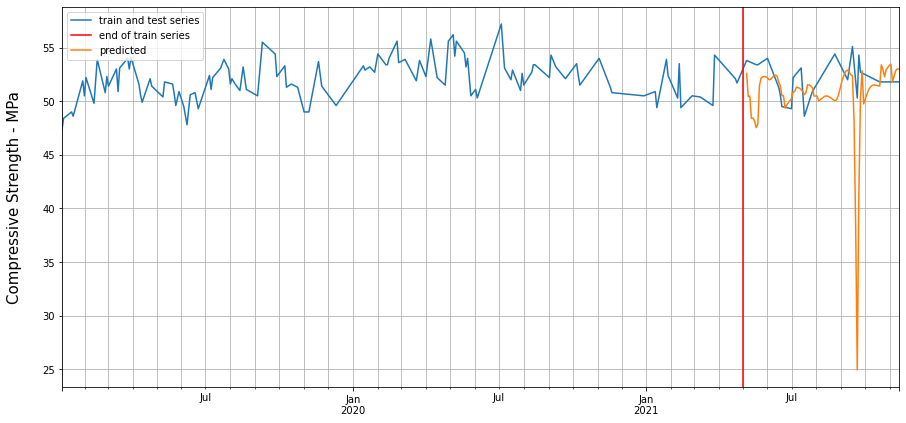

In [13]:
plot_time_series_train_and_prediction_windows(df, model, cut_date)

<h3>Different number of timesteps</h3>

In [14]:
df = df_no_r3d_r7d.copy()

for time_steps in time_steps_list:
    x_train, y_train, x_test, y_test = get_times_series_data(df, cut_date, time_steps=time_steps)
    x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
    x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

    model = get_baseline_model()
    model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
    rmse = model.evaluate(x_test, y_test, verbose=0)
    print('TIMESTEPS: %d, RMSE: %.3f' % (time_steps, rmse[1]))

TIMESTEPS: 1, RMSE: 3.419
TIMESTEPS: 3, RMSE: 5.441
TIMESTEPS: 5, RMSE: 4.555
TIMESTEPS: 7, RMSE: 2.021
TIMESTEPS: 10, RMSE: 1.555
TIMESTEPS: 15, RMSE: 1.517
TIMESTEPS: 20, RMSE: 1.395


<h3> Baseline model - Dataset: df_r3d_only</h3>

In [15]:
df = df_r3d_only.copy()
x_train, y_train, x_test, y_test = get_times_series_data(df, cut_date)
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

In [16]:
model = get_baseline_model()
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
rmse = model.evaluate(x_test, y_test, verbose=0)
print('RMSE: %.3f' % rmse[1])

RMSE: 4.679


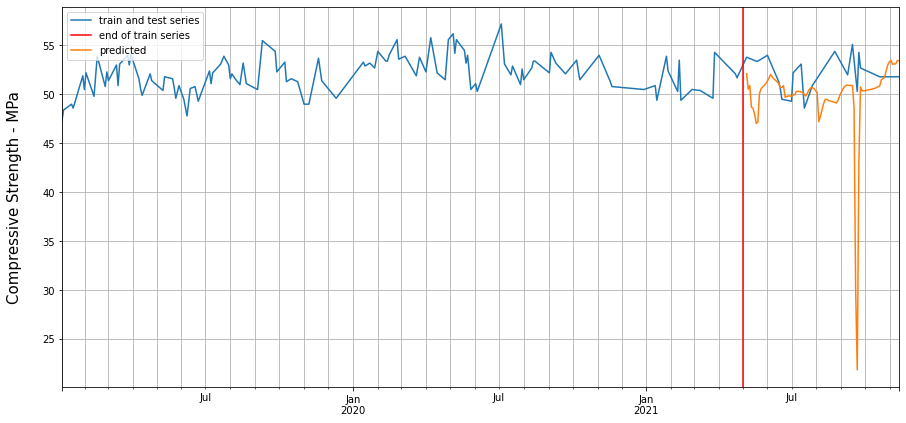

In [17]:
plot_time_series_train_and_prediction_windows(df, model, cut_date)

<h3>Different number of timesteps</h3>

In [18]:
df = df_r3d_only.copy()

for time_steps in time_steps_list:
    x_train, y_train, x_test, y_test = get_times_series_data(df, cut_date, time_steps=time_steps)
    x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
    x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

    model = get_baseline_model()
    model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
    rmse = model.evaluate(x_test, y_test, verbose=0)
    print('TIMESTEPS: %d, RMSE: %.3f' % (time_steps, rmse[1]))

TIMESTEPS: 1, RMSE: 3.790
TIMESTEPS: 3, RMSE: 3.696
TIMESTEPS: 5, RMSE: 2.452
TIMESTEPS: 7, RMSE: 2.654
TIMESTEPS: 10, RMSE: 1.498
TIMESTEPS: 15, RMSE: 1.390
TIMESTEPS: 20, RMSE: 1.511


<h3> Baseline model - Dataset: df_r3d_and_r7d</h3>

In [19]:
df = df_r3d_and_r7d.copy()
x_train, y_train, x_test, y_test = get_times_series_data(df, '2021-05-02')
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

In [20]:
model = get_baseline_model()
model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=0)
rmse = model.evaluate(x_test, y_test, verbose=0)
print('RMSE: %.3f' % rmse[1])

RMSE: 3.468


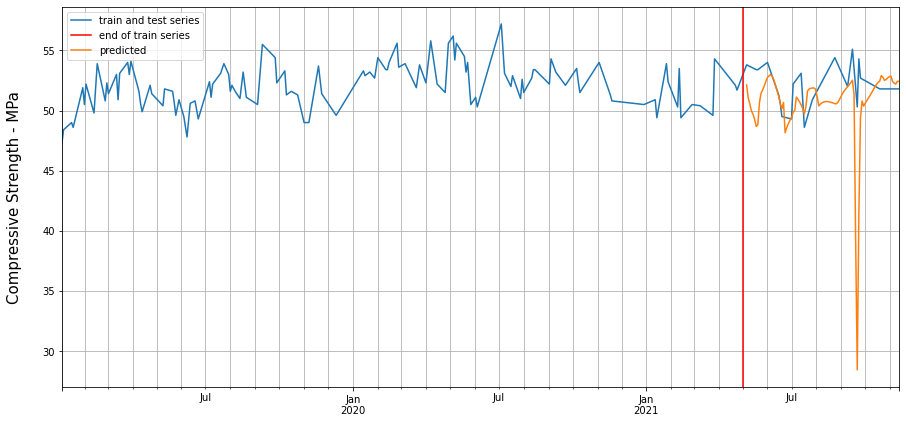

In [21]:
plot_time_series_train_and_prediction_windows(df, model, cut_date)

<h3>Different number of timesteps</h3>

In [22]:
df = df_no_r3d_r7d.copy()

for time_steps in time_steps_list:
    x_train, y_train, x_test, y_test = get_times_series_data(df, cut_date, time_steps=time_steps)
    x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
    x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

    model = get_baseline_model()
    model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
    rmse = model.evaluate(x_test, y_test, verbose=0)
    print('TIMESTEPS: %d, RMSE: %.3f' % (time_steps, rmse[1]))

TIMESTEPS: 1, RMSE: 4.360
TIMESTEPS: 3, RMSE: 2.863
TIMESTEPS: 5, RMSE: 2.461
TIMESTEPS: 7, RMSE: 1.809
TIMESTEPS: 10, RMSE: 1.851
TIMESTEPS: 15, RMSE: 2.649
TIMESTEPS: 20, RMSE: 1.382


# Grid Search CV

Before doing Repeated Cross Validation, we shall search for the best parameters. To do so, Keras Tuner will be used
to accomplish the Grid Search.

<h3>GridCV - Scikit Learn</h3>

In [23]:
def create_keras_model(activation='tanh', dropout_rate=0.0, n_units=64, n_layers=1, learning_rate=1e-3):
    model = tf.keras.Sequential()
    
    for i in range(n_layers):
        if i + 1 < n_layers:
            model.add(tf.keras.layers.LSTM(units=n_units, activation=activation, return_sequences=True))
        else:
            model.add(tf.keras.layers.LSTM(units=n_units, activation=activation, return_sequences=False))
    if  dropout_rate > 0.0:
        model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="mse",
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")])
    return model

In [24]:
def make_grid_search(x, y):
    activation = ['tanh', 'relu', 'swish']
    dropout_rate = [0.0, 0.1]
    n_units = [32, 64]
    n_layers = [1, 2, 3]
    learning_rate = [0.001, 0.01, 0.1]
    epochs = [100]
    batches = [32]

    param_grid = dict(model__activation=activation,
                      model__dropout_rate=dropout_rate, 
                      model__n_units=n_units,
                      model__n_layers=n_layers, 
                      model__learning_rate=learning_rate,
                      model__epochs=epochs,
                      model__batch_size=batches)

    model = KerasRegressor(build_fn=create_keras_model, epochs=30, batch_size=32, verbose=0)
    pipeline = Pipeline(steps=[('transformer', StandardScaler3DShape()), ('model', model)])

    grid = GridSearchCV(estimator=pipeline, 
                        param_grid=param_grid,
                        n_jobs=-1,
                        cv=3, 
                        scoring='neg_root_mean_squared_error')
    
    grid_result = grid.fit(x, y)

    print("Best: %f using %s\n" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid

<h3>GridCV 1</h3>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [25]:
df = df_no_r3d_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

start = time.time()
gridcv1 = make_grid_search(x, y)
end = time.time()
print("\nMinutes Elapsed: ", (end - start)/60)

/tmp/ipykernel_715779/3700414713.py:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasRegressor(build_fn=create_keras_model, epochs=30, batch_size=32, verbose=0)


Best: -1.735369 using {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.01, 'model__n_layers': 3, 'model__n_units': 32}

-13.172469 (0.472563) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 1, 'model__n_units': 32}
-5.079896 (3.142578) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 1, 'model__n_units': 64}
-14.148718 (1.105009) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 2, 'model__n_units': 32}
-3.839396 (2.910711) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_la

In [26]:
gridcv1.best_params_

{'model__activation': 'tanh',
 'model__batch_size': 32,
 'model__dropout_rate': 0.0,
 'model__epochs': 100,
 'model__learning_rate': 0.01,
 'model__n_layers': 3,
 'model__n_units': 32}

<h3>GridCV 2</h3>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D is considered.

In [27]:
df = df_r3d_only.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

start = time.time()
gridcv2 = make_grid_search(x, y)
end = time.time()
print("\nMinutes Elapsed: ", (end - start)/60)

/tmp/ipykernel_715779/3700414713.py:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasRegressor(build_fn=create_keras_model, epochs=30, batch_size=32, verbose=0)


Best: -1.745063 using {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.01, 'model__n_layers': 3, 'model__n_units': 32}

-13.077028 (0.978286) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 1, 'model__n_units': 32}
-7.157363 (6.508780) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 1, 'model__n_units': 64}
-16.651816 (4.872754) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 2, 'model__n_units': 32}
-6.550297 (6.907011) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_la

In [28]:
gridcv2.best_params_

{'model__activation': 'tanh',
 'model__batch_size': 32,
 'model__dropout_rate': 0.0,
 'model__epochs': 100,
 'model__learning_rate': 0.01,
 'model__n_layers': 3,
 'model__n_units': 32}

<h3>GridCV 3</h3>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset R3D and R7D are considered.

In [29]:
df = df_r3d_and_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

start = time.time()
gridcv3 = make_grid_search(x, y)
end = time.time()
print("\nMinutes Elapsed: ", (end - start)/60)

/tmp/ipykernel_715779/3700414713.py:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasRegressor(build_fn=create_keras_model, epochs=30, batch_size=32, verbose=0)


Best: -1.681352 using {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.1, 'model__epochs': 100, 'model__learning_rate': 0.1, 'model__n_layers': 3, 'model__n_units': 32}

-13.106613 (1.273860) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 1, 'model__n_units': 32}
-6.454866 (5.977436) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 1, 'model__n_units': 64}
-15.686347 (3.453194) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 2, 'model__n_units': 32}
-2.959708 (1.778980) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_lay

In [30]:
gridcv3.best_params_

{'model__activation': 'tanh',
 'model__batch_size': 32,
 'model__dropout_rate': 0.1,
 'model__epochs': 100,
 'model__learning_rate': 0.1,
 'model__n_layers': 3,
 'model__n_units': 32}

<h2>Times Series KFold Cross validation</h2>

Here we will make a Times Series KFold Cross validation with all 3 datasets. Here we are using the <b>Blocking           Time Series Split</b> method. And with timeseries Split method


In [31]:
def make_repeated_time_series_k_fold(x, 
                                     y, 
                                     train_period, 
                                     test_period,
                                     grid=None,
                                     repeats=10,
                                     show_individual_results=True,
                                     show_final_result=True,
                                     params=None):
    results = []
    max_samples = x.shape[0]
    
    if grid:
        activation = grid.best_params_['model__activation']
        dropout_rate = grid.best_params_['model__dropout_rate']
        n_units = grid.best_params_['model__n_units']
        n_layers = grid.best_params_['model__n_layers']
        learning_rate = grid.best_params_['model__learning_rate']
        batch_size = grid.best_params_['model__batch_size']
        epochs = grid.best_params_['model__epochs']
    else:
        activation = params['activation']
        dropout_rate = params['dropout_rate']
        n_units = params['n_units']
        n_layers = params['n_layers']
        learning_rate = params['learning_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']
    
    for _ in range(repeats):
        i = 0
        scores = []
        for _ in range(0, max_samples//train_period):
            x_train = x[i:i+train_period]
            y_train = y[i:i+train_period]
            x_test = x[i+train_period: i+train_period+test_period]
            y_test = y[i+train_period: i+train_period+test_period]
            i += train_period
            x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
            x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
            model = create_keras_model(activation=activation,
                                       dropout_rate=dropout_rate,
                                       n_units=n_units,
                                       n_layers=n_layers,
                                       learning_rate=learning_rate)
            model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
            rmse = model.evaluate(x_test, y_test, verbose=0)
            scores.append(rmse[1])
        results.append(scores)
        if show_individual_results:
            print('RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    if show_final_result:
        print('\nRMSE: %.3f (%.3f)' % (np.mean(results), np.std(results)))
    return results
    

<h3> Time Series Repeated KFold Cross Validation - df_no_r3d_r7d</h3>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [32]:
df = df_no_r3d_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [33]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv1, repeats)

RMSE: 1.669 (0.288)
RMSE: 1.696 (0.261)
RMSE: 1.703 (0.248)
RMSE: 1.712 (0.237)
RMSE: 1.700 (0.256)
RMSE: 1.710 (0.232)
RMSE: 1.688 (0.285)
RMSE: 1.691 (0.271)
RMSE: 1.724 (0.283)
RMSE: 1.724 (0.254)

RMSE: 1.702 (0.263)


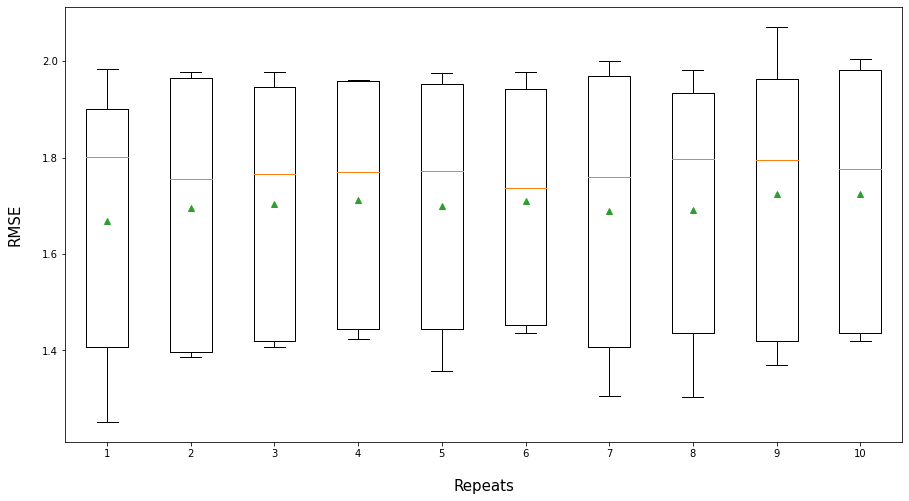

In [34]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [35]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv1, repeats)

RMSE: 1.109 (0.186)
RMSE: 1.138 (0.249)
RMSE: 1.128 (0.215)
RMSE: 1.103 (0.223)
RMSE: 1.104 (0.202)
RMSE: 1.054 (0.189)
RMSE: 1.120 (0.213)
RMSE: 1.108 (0.211)
RMSE: 1.097 (0.230)
RMSE: 1.265 (0.036)

RMSE: 1.123 (0.210)


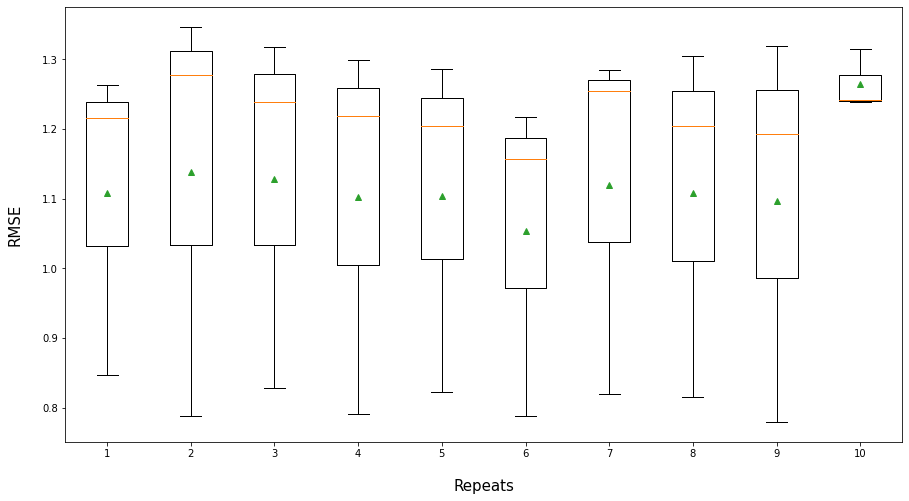

In [36]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [37]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv1, repeats)

RMSE: 0.532 (0.000)
RMSE: 0.531 (0.000)
RMSE: 0.537 (0.000)
RMSE: 0.529 (0.000)
RMSE: 0.599 (0.000)
RMSE: 0.548 (0.000)
RMSE: 0.530 (0.000)
RMSE: 0.887 (0.000)
RMSE: 0.529 (0.000)
RMSE: 0.848 (0.000)

RMSE: 0.607 (0.132)


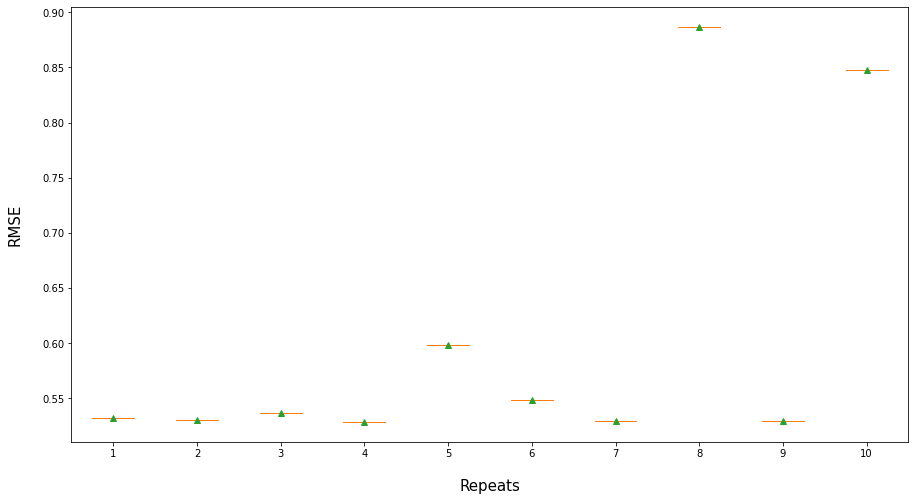

In [38]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h3> Time Series Repeated KFold Cross Validation - df_r3d_only</h3>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D variable is considered.

In [39]:
df = df_r3d_only.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [40]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv2, repeats)

RMSE: 1.725 (0.256)
RMSE: 1.686 (0.238)
RMSE: 1.689 (0.264)
RMSE: 1.711 (0.242)
RMSE: 1.689 (0.249)
RMSE: 1.700 (0.236)
RMSE: 1.666 (0.249)
RMSE: 1.722 (0.249)
RMSE: 1.692 (0.234)
RMSE: 1.699 (0.243)

RMSE: 1.698 (0.247)


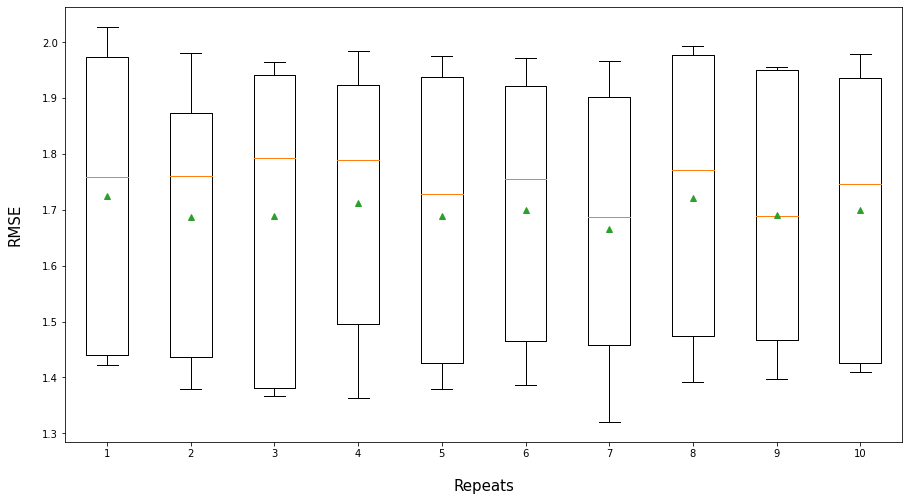

In [41]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [42]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv2, repeats)

RMSE: 1.112 (0.197)
RMSE: 1.116 (0.204)
RMSE: 1.089 (0.209)
RMSE: 1.120 (0.199)
RMSE: 1.058 (0.165)
RMSE: 1.084 (0.206)
RMSE: 1.108 (0.201)
RMSE: 1.109 (0.209)
RMSE: 1.118 (0.205)
RMSE: 1.143 (0.218)

RMSE: 1.106 (0.203)


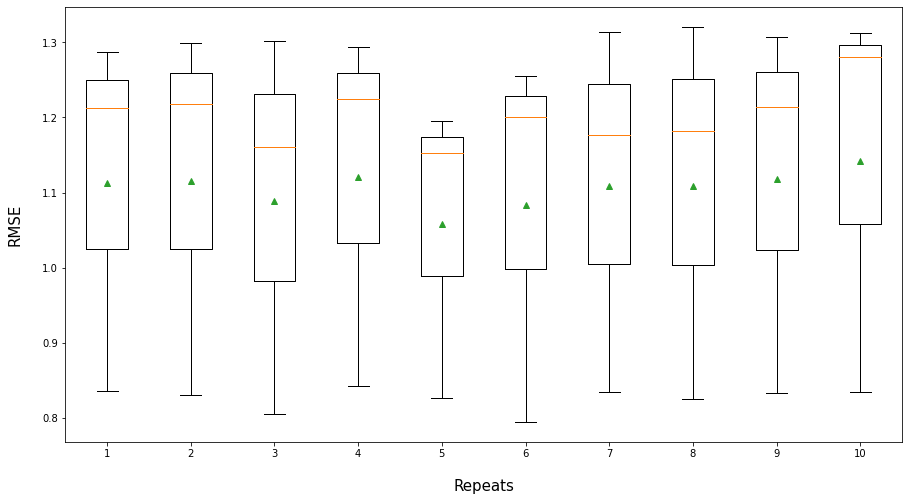

In [43]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [44]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv2, repeats)

RMSE: 0.576 (0.000)
RMSE: 0.555 (0.000)
RMSE: 0.529 (0.000)
RMSE: 0.530 (0.000)
RMSE: 0.555 (0.000)
RMSE: 0.541 (0.000)
RMSE: 0.531 (0.000)
RMSE: 0.573 (0.000)
RMSE: 0.529 (0.000)
RMSE: 0.529 (0.000)

RMSE: 0.545 (0.018)


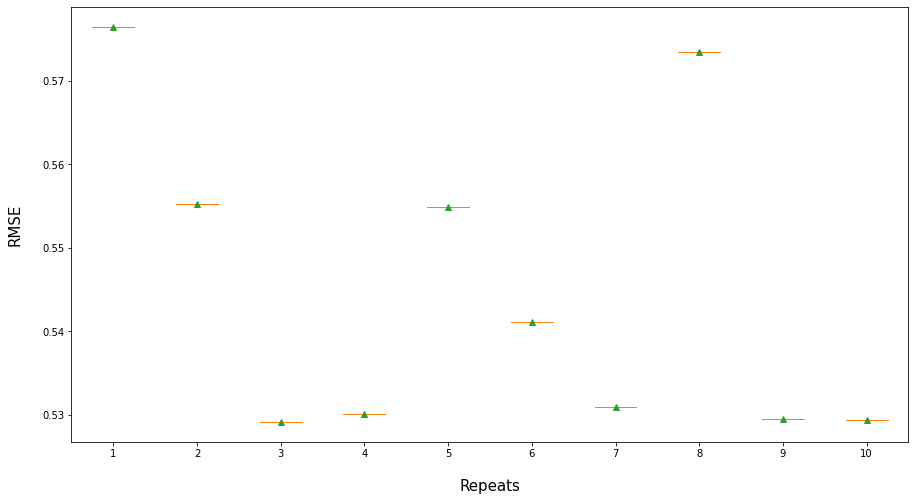

In [45]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h3> Time Series Repeated KFold Cross Validation - df_r3d_and_r7d</h3>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset both R3D and R7D variables are considered.

In [46]:
df = df_r3d_and_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [47]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv3, repeats)

RMSE: 1.706 (0.385)
RMSE: 1.548 (0.355)
RMSE: 3.667 (3.704)
RMSE: 1.651 (0.370)
RMSE: 1.776 (0.327)
RMSE: 1.667 (0.164)
RMSE: 1.925 (0.537)
RMSE: 5.223 (7.336)
RMSE: 1.742 (0.160)
RMSE: 1.742 (0.457)

RMSE: 2.265 (2.860)


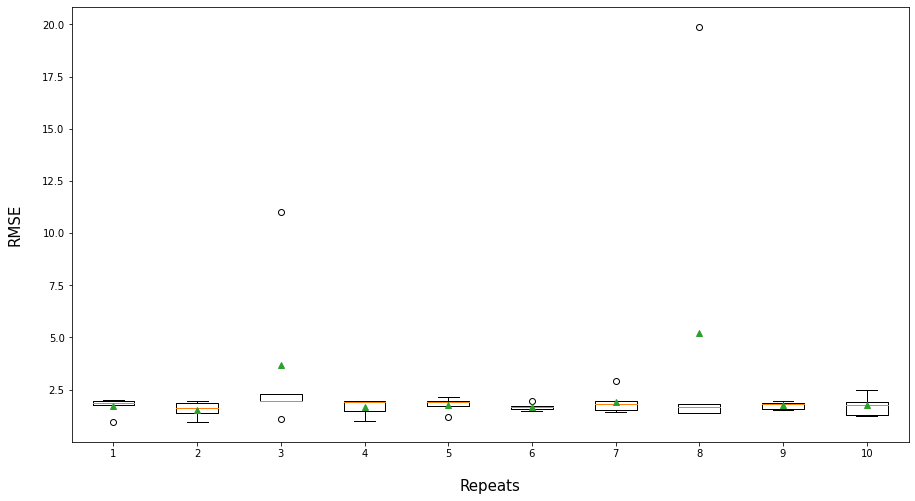

In [48]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [49]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv3, repeats)

RMSE: 1.079 (0.249)
RMSE: 1.194 (0.003)
RMSE: 6.542 (7.546)
RMSE: 1.041 (0.338)
RMSE: 1.337 (0.221)
RMSE: 1.573 (0.545)
RMSE: 1.266 (0.451)
RMSE: 1.179 (0.431)
RMSE: 1.322 (0.370)
RMSE: 1.646 (0.821)

RMSE: 1.818 (2.895)


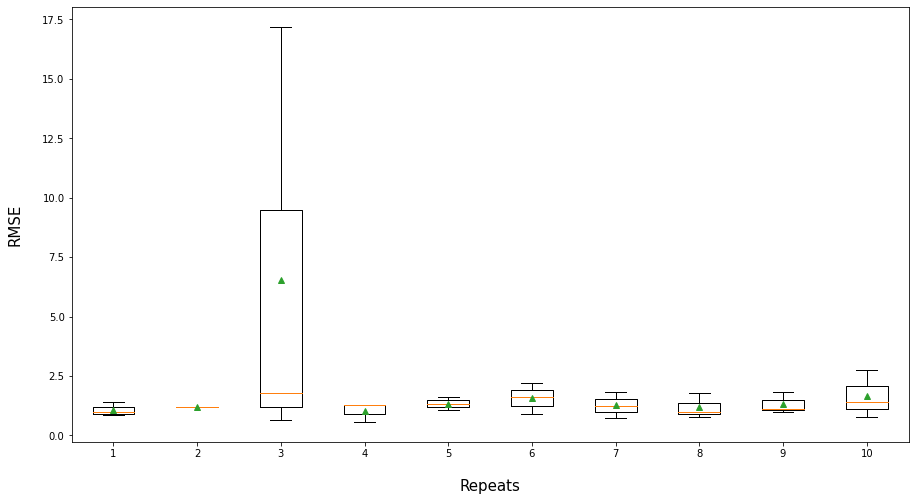

In [50]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [51]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv3, repeats)

RMSE: 0.531 (0.000)
RMSE: 1.215 (0.000)
RMSE: 1.114 (0.000)
RMSE: 0.529 (0.000)
RMSE: 0.529 (0.000)
RMSE: 0.618 (0.000)
RMSE: 0.528 (0.000)
RMSE: 1.305 (0.000)
RMSE: 1.161 (0.000)
RMSE: 1.086 (0.000)

RMSE: 0.862 (0.320)


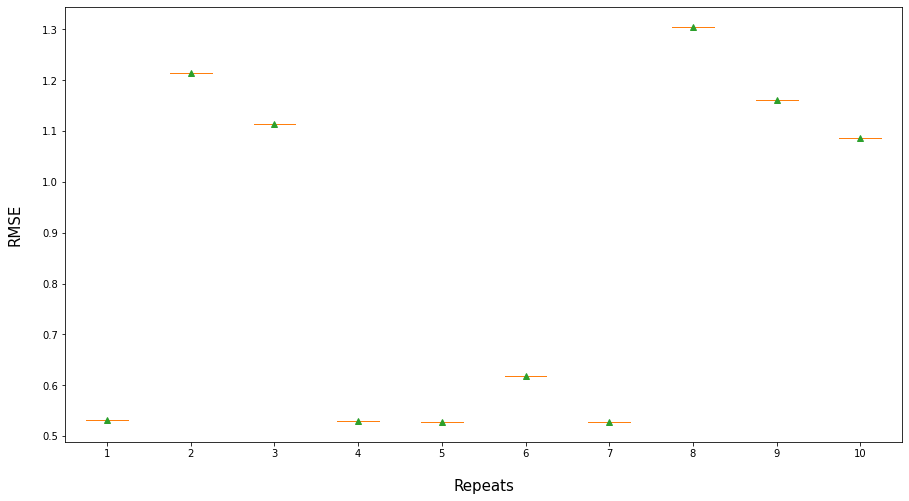

In [52]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

# Times Series Repeated KFold Cross validation - different Timesteps values

Here we will make a Times Series KFold Cross validation with all 3 datasets. Here we are using the Blocking Time Series Split method. And with timeseries Split method. We also do it with different number of timesteps


# Configs

<h3>Model</h3>
   
    LSTM Cells: 64
    LSTM Layers: 1
    Optimization Algorithm: Adam  
        Learning Rate: 1e-2
    Epochs: 100
    Batch size: 32


    
    
<h3>Timesteps: </h3>

    TIMESTEPS: [1, 3, 5, 7, 10, 15, 20]

<h3>Repeats: 10</h3>

In [53]:
def make_timesteps_repeated_time_series_k_fold(df,
                                               train_period,
                                               test_period,
                                               params=None,
                                               grid=None,
                                               repeats=10,
                                               timesteps_list=[3],
                                               show_results=True):
    results = {}
    
    for timesteps in timesteps_list:
        x, y = split_sequences(df.values, timesteps)
        scores = make_repeated_time_series_k_fold(x, y, train_period, test_period, grid, repeats, False, False, params)
        results[timesteps] = scores
        if show_results:
            print('TIMESTEPS: %d RMSE: %.3f (%.3f)' % (timesteps, np.mean(scores), np.std(scores)))
    return results

In [54]:
params = {}
params['activation'] = 'tanh'
params['dropout_rate'] = 0.0
params['n_units'] = 64
params['n_layers'] = 1
params['learning_rate'] = 1e-2
params['batch_size'] = 32
params['epochs'] = 100

timesteps_list = [1, 3, 5, 7, 10, 15, 20]

repeats = 10

<h3> Time Series Repeated KFold Cross Validation with vary timesteps - df_no_r3d_r7d</h3>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [55]:
df = df_no_r3d_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [56]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month

<b>Baseline model</b>

In [57]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)

TIMESTEPS: 1 RMSE: 11.360 (6.120)
TIMESTEPS: 3 RMSE: 5.004 (4.955)
TIMESTEPS: 5 RMSE: 4.509 (9.000)
TIMESTEPS: 7 RMSE: 2.356 (3.740)
TIMESTEPS: 10 RMSE: 2.146 (3.286)
TIMESTEPS: 15 RMSE: 4.142 (7.772)
TIMESTEPS: 20 RMSE: 1.701 (1.932)


<b>gridcv1 model</b>

In [58]:
# results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, None, gridcv1, repeats, timesteps_list)

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [59]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month

<b>Baseline model</b>

In [60]:
start = time.time()
results = results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)
end = time.time()
print("\nMinutes Elapsed: ", (end - start)/60)


TIMESTEPS: 1 RMSE: 11.287 (5.887)
TIMESTEPS: 3 RMSE: 1.987 (1.977)
TIMESTEPS: 5 RMSE: 1.172 (0.606)
TIMESTEPS: 7 RMSE: 1.804 (3.834)
TIMESTEPS: 10 RMSE: 1.139 (0.797)
TIMESTEPS: 15 RMSE: 2.790 (8.713)
TIMESTEPS: 20 RMSE: 1.409 (0.985)

Minutes Elapsed:  24.052198882897695


<b>gridcv1 model</b>

In [61]:
# start = time.time()
# results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, None, gridcv1, repeats, timesteps_list)
# end = time.time()
# print("\nMinutes Elapsed: ", (end - start)/60)

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [62]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months

<b>Baseline model</b>

In [63]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)

TIMESTEPS: 1 RMSE: 6.448 (2.157)
TIMESTEPS: 3 RMSE: 1.720 (0.127)
TIMESTEPS: 5 RMSE: 1.614 (0.183)
TIMESTEPS: 7 RMSE: 0.942 (0.270)
TIMESTEPS: 10 RMSE: 0.660 (0.307)
TIMESTEPS: 15 RMSE: 0.488 (0.193)
TIMESTEPS: 20 RMSE: 0.589 (0.252)


<b>gridcv1 model</b>

In [64]:
# results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, None, gridcv1, repeats, timesteps_list)

<h3> Time Series Repeated KFold Cross Validation - df_r3d_only</h3>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D variable is considered.

In [65]:
df = df_r3d_only.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [66]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month

<b>Baseline model</b>

In [67]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)

TIMESTEPS: 1 RMSE: 11.862 (6.478)
TIMESTEPS: 3 RMSE: 4.575 (5.088)
TIMESTEPS: 5 RMSE: 2.318 (2.055)
TIMESTEPS: 7 RMSE: 2.358 (3.662)
TIMESTEPS: 10 RMSE: 2.091 (4.104)
TIMESTEPS: 15 RMSE: 2.565 (5.604)
TIMESTEPS: 20 RMSE: 2.277 (5.623)


<b>gridcv2 model</b>

In [68]:
# results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, None, gridcv2, repeats, timesteps_list)

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [69]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month

<b>Baseline model</b>

In [70]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)

TIMESTEPS: 1 RMSE: 11.515 (6.123)
TIMESTEPS: 3 RMSE: 2.938 (3.165)
TIMESTEPS: 5 RMSE: 2.262 (5.164)
TIMESTEPS: 7 RMSE: 3.870 (10.769)
TIMESTEPS: 10 RMSE: 1.868 (3.738)
TIMESTEPS: 15 RMSE: 2.805 (8.769)
TIMESTEPS: 20 RMSE: 2.949 (7.037)


<b>gridcv2 model</b>

In [71]:
# results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, None, gridcv2, repeats, timesteps_list)

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [72]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months

<b>Baseline model</b>

In [73]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)

TIMESTEPS: 1 RMSE: 6.197 (1.783)
TIMESTEPS: 3 RMSE: 1.794 (0.136)
TIMESTEPS: 5 RMSE: 1.442 (0.165)
TIMESTEPS: 7 RMSE: 0.993 (0.313)
TIMESTEPS: 10 RMSE: 0.854 (0.286)
TIMESTEPS: 15 RMSE: 0.830 (0.347)
TIMESTEPS: 20 RMSE: 0.613 (0.193)


<b>gridcv2 model</b>

In [74]:
# results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, None, gridcv2, repeats, timesteps_list)

<h3> Time Series Repeated KFold Cross Validation - df_r3d_and_r7d</h3>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset both R3D and R7D variables are considered.

In [75]:
df = df_r3d_and_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [76]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month

<b>Baseline model</b>

In [77]:
results = results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)

TIMESTEPS: 1 RMSE: 11.952 (7.310)
TIMESTEPS: 3 RMSE: 4.017 (4.657)
TIMESTEPS: 5 RMSE: 2.688 (4.344)
TIMESTEPS: 7 RMSE: 2.382 (3.835)
TIMESTEPS: 10 RMSE: 3.507 (7.617)
TIMESTEPS: 15 RMSE: 2.448 (4.956)
TIMESTEPS: 20 RMSE: 1.799 (2.491)


<b>gridcv3 model</b>

In [78]:
# results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, None, gridcv3, repeats, timesteps_list)

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [79]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month

<b>Baseline model</b>

In [80]:
results = results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)

TIMESTEPS: 1 RMSE: 12.185 (6.605)
TIMESTEPS: 3 RMSE: 4.077 (5.189)
TIMESTEPS: 5 RMSE: 1.567 (1.981)
TIMESTEPS: 7 RMSE: 4.362 (10.498)
TIMESTEPS: 10 RMSE: 4.264 (11.923)
TIMESTEPS: 15 RMSE: 1.231 (0.958)
TIMESTEPS: 20 RMSE: 1.379 (0.971)


<b>gridcv3 model</b>

In [81]:
# results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, None, gridcv3, repeats, timesteps_list)

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [82]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months

<b>Baseline model</b>

In [83]:
results = results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)

TIMESTEPS: 1 RMSE: 6.648 (1.313)
TIMESTEPS: 3 RMSE: 1.787 (0.185)
TIMESTEPS: 5 RMSE: 1.512 (0.073)
TIMESTEPS: 7 RMSE: 1.079 (0.311)
TIMESTEPS: 10 RMSE: 0.486 (0.174)
TIMESTEPS: 15 RMSE: 0.644 (0.348)
TIMESTEPS: 20 RMSE: 0.412 (0.078)


<b>gridcv3 model</b>

In [84]:
# results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, None, gridcv3, repeats, timesteps_list)